# Measuring stability

A widely used metric for atmospheric stability is the gradient of potential temperature between the the free troposphere ($\approx 700 hPa$) and the surface, the *lower troposheric stability* (LTS).

$$ LTS = \theta_{700hPa} - \theta_{surface} \quad(3)$$ 

The LTS is an implicit composit of two ingredients: The lapse rate and the boundary layer inversion. The *estimated inversion strength* builds upon LTS and substracts the (linearly estimated) lapse rate effect.

$$ EIS = LTS - \Gamma_m (z_{700hPa} - z_{LCL}) \quad(4)$$ 

(Both equations Eq. 3 and 4 from [Wang et al., 2023](https://acp.copernicus.org/articles/23/3247/2023/))



This figure from [Wood and Bretherton (2006)](https://journals.ametsoc.org/view/journals/clim/19/24/jcli3988.1.xml?tab_body=fulltext-display) provides a good overview over the relationship of these metrics and their relationship to the potential temperature profile:

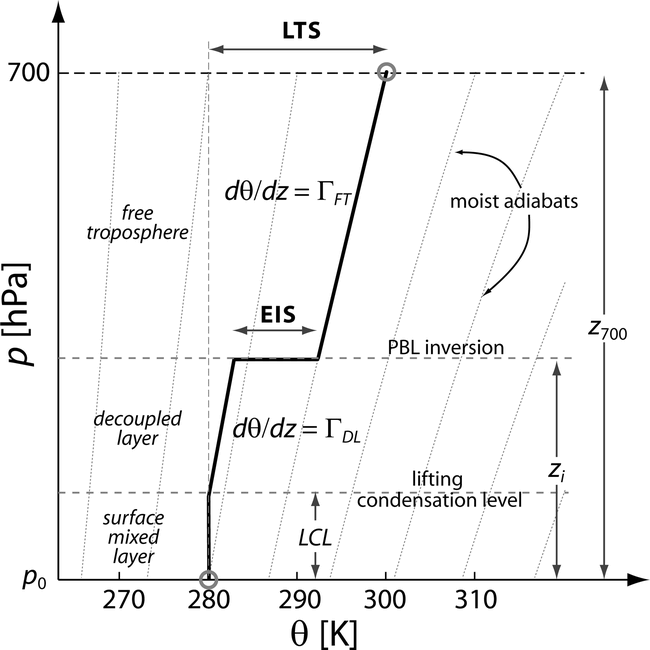

Although I do have pressure level output for the warming experiment, I do not for the control simulation. Thus I will work with the 3D output.

In [1]:
import sys
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)

import file_handling as fh
import postprocessing as pp
fh.disable_warnings()

Any code that generates warnings will no longer print them to the console.


In [2]:
import xarray as xr

def filter_common_vars(datasets):
    common_vars = set.intersection(*[set(ds.variables) for ds in datasets])
    return [ds[common_vars] for ds in datasets]

def load_data(exp_dir = '/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_05/',
              file_slice=slice(50,53)):
    kind = '3D'
    data = fh.disk_data_from_keywords(exp_dir, [kind, 'DOM01'], return_file_list=1)
    data = data[file_slice]
    data = xr.open_mfdataset(data)
    data = pp.clean_volume_data(data)
    data = data.expand_dims(exp=('warming',))
    data = add_control(data)
    data = pp.replace_height_indices_with_values(data)
    return data

def add_control(input_data):
    datasets = list()
    for kind in ['3D_DOM']:
        data = fh.eureca_data_from_keywords([kind, 'DOM01'])
        datasets.append(data)
    datasets = pp.subset_time_overlap(datasets)
    data = xr.merge(datasets)
    data = data.expand_dims(exp=('control',))

    datasets = [input_data, data]
    datasets = pp.filter_common_vars(datasets)
    datasets = pp.subset_time_overlap(datasets)
    return xr.concat(datasets, dim='exp')
    return data

data = load_data(file_slice=slice(180,183))
# data = data.median(dim='cell', keep_attrs=True)
data = data.mean(dim='cell', keep_attrs=True)

## LTS from 3D data
$$ LTS = \theta_{700hPa} - \theta_{surface}$$ 

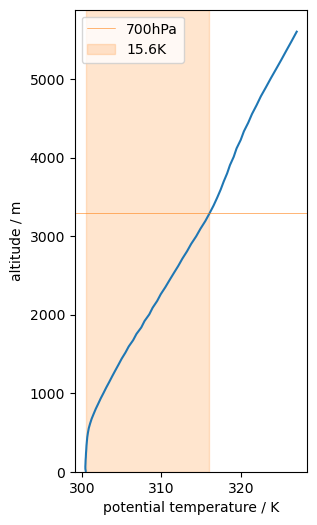

In [3]:
import numpy as np
import calculations as cc
import matplotlib.pyplot as plt

d = data.isel(time=0)
d = d.sel(exp='warming')
d = cc.add_prognostic_variables(d)

index_700hPa = cc.index_of_nearest_value(d.pres.values, 70000)
theta = d['theta'].values
lts = theta[index_700hPa] - theta[-1]

fig, ax = plt.subplots(figsize=(3,6))
y = d.height.values
axline_kwargs = dict(color='tab:orange', lw=.4)

ax.plot(d['theta'], y)
label = f'{d.height.values[index_700hPa]/1000:.1f}km'
label = f'700hPa'
ax.axhline(y[index_700hPa], **axline_kwargs, label=label)
ax.axvspan(theta[index_700hPa], theta[-1], color=axline_kwargs['color'], alpha=.2, label=f'{lts:.1f}K')
ax.set_ylim(0,None)
ax.legend()
ax.set_xlabel('potential temperature / K')
ax.set_ylabel('altitude / m')

fig.show()

## LCL

The Lifting Condensation Level (LCL) is the level at which a parcel becomes saturated. It can be used as a reasonable estimate of cloud base height when parcels experience forced ascent [¹](https://www.weather.gov/btv/profileLCL) and it marks the transition between dry and moist adiabat. We need to calculate the LCL to compute the *estimated inversion strength*. 

In [4]:
import metpy.calc 
from metpy.units import units as mpunit

d = data.isel(time=0)
d = d.sel(exp='warming')

pressure          = d['pres'] * mpunit('Pa')
temperature       = d['temp'] * mpunit('K')
specific_humidity = d['qv']
dewpoint = metpy.calc.dewpoint_from_specific_humidity(pressure, temperature, specific_humidity)
LCL_pres, LCL_temp = metpy.calc.lcl(pressure, temperature, dewpoint)
LCL = {'pres':LCL_pres.magnitude.compute(), 'temp':LCL_temp.magnitude.compute()}

/sw/spack-levante/mambaforge-23.1.0-1-Linux-x86_64-3boc6i/lib/python3.10/site-packages/dask/array/core.py:1713: FutureWarning: The `numpy.copyto` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(
/sw/spack-levante/mambaforge-23.1.0-1-Linux-x86_64-3boc6i/lib/python3.10/site-packages/dask/array/core.py:1713: FutureWarning: The `numpy.place` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(
/sw/spack-levante/mambaforge-23.1.0-1-Linux-x86_64-3boc6i/lib/python3.10/site-packages/dask/array/core.py:1713: FutureWarning: The `numpy.copyto` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop workin

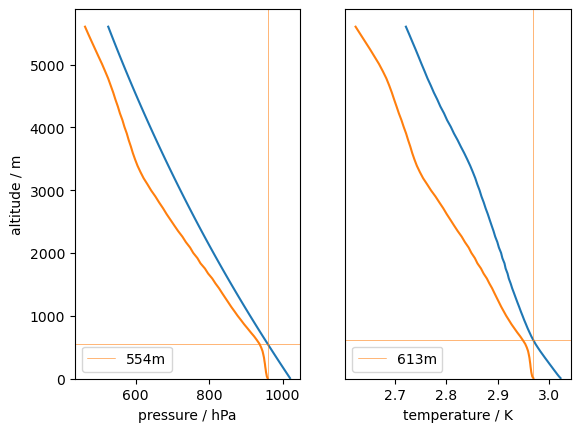

In [5]:
import matplotlib.pyplot as plt
import plot_utils as pu
import numpy as np

fig, axs = plt.subplots(1,2)
y = d.height.values
axline_kwargs = dict(color='tab:orange', lw=.4)

for var, ax in zip(['pres', 'temp'], axs):
    if var == 'pres':
        mulitplier = 0.01
        ax.set_xlabel('pressure / hPa')
    else:
        multiplier = 1.00
        ax.set_xlabel('temperature / K')
        
    ax.plot(d[var] * mulitplier, y)#, label='data')
    ax.plot(LCL[var] * mulitplier, y)#, label='corresponding LCL value')

    surface_value = LCL[var][-1]
    index = np.argmin(np.abs(d[var].values - surface_value))
    ax.axvline(surface_value * mulitplier, **axline_kwargs)
    ax.axhline(y[index], label=f'{y[index]:.0f}m', **axline_kwargs)
    
    ax.legend()
    ax.set_ylim(0,None)

axs[0] = axs[0].set_ylabel('altitude / m')
axs[1] = pu.remove_ticks(axs[1], ['left','right'])

fig.show()

In our plot above we show the LCL for each level, both isothermal lifting to a lower pressure level, or a isobaric lifting to a lower temperature level. As the potential temperature stays relatively constant throughout the well mixed surface layer, below the level where condensation starts, the LCL estimate does the same. The potential temperture also gives us an additional hint of the actual position of the LCL.

Taking the isothermal LCL of a surface air parcel seems a reasonable approximation.

## EIS

$$ EIS = LTS + \Gamma_m (z_{700hPa} - z_{LCL})$$ 

In [6]:
def lcl_height(data, assumption='isobaric', return_index=False):    
    pressure          = d['pres'] * mpunit('Pa')
    temperature       = d['temp'] * mpunit('K')
    specific_humidity = d['qv']
    dewpoint = metpy.calc.dewpoint_from_specific_humidity(pressure, temperature, specific_humidity)
    LCL_pres, LCL_temp = metpy.calc.lcl(pressure[-1], temperature[-1], dewpoint[-1], eps=1e-2) 
    if   assumption == 'isobaric':
        index = np.argmin(np.abs(d['pres'].values - LCL_pres.magnitude.compute()))
    elif assumption == 'isothermal':
        index = np.argmin(np.abs(d['temp'].values - LCL_temp.magnitude.compute()))
    else: 
        raise ValueError(f"Assumption has to be one of ['isobaric', 'isothermal']. '{assumption}' given.")

    if return_index:
        return index
    else:
        return data.height.values[index]
    
d = data.isel(time=0)
d = d.sel(exp='warming')
print('LCL height:', lcl_height(d))

/sw/spack-levante/mambaforge-23.1.0-1-Linux-x86_64-3boc6i/lib/python3.10/site-packages/dask/array/core.py:1713: FutureWarning: The `numpy.copyto` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(
/sw/spack-levante/mambaforge-23.1.0-1-Linux-x86_64-3boc6i/lib/python3.10/site-packages/dask/array/core.py:1713: FutureWarning: The `numpy.place` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(
/sw/spack-levante/mambaforge-23.1.0-1-Linux-x86_64-3boc6i/lib/python3.10/site-packages/dask/array/core.py:1713: FutureWarning: The `numpy.copyto` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop workin

LCL height: 553.570556640625


[Wood and Bretherton (2006)](https://journals.ametsoc.org/view/journals/clim/19/24/jcli3988.1.xml?tab_body=fulltext-display) also provide a formulation of local lapse rate: 

$\Gamma_m(T,p) = \frac{g}{c_p} \Big[ 1 - \frac{1 + L_v q_s(T,p) R_a^{-1}T^{-1}}{1 + L_v^2 q_s(T,p) c_p^{-1}R_v^{-1}T^{-2}} \Big], \quad(5)$ 

where 
- $L_υ$ is the latent heat of vaporization
- $q_s$ is the saturation mixing ratio,
- $R_a$ and $R_υ$ are the gas constants for dry and water vapor, respectively,
- $g$ is the gravitational acceleration, and
- $c_p$ is the specific heat of air at constant pressure.

<!-- $z_{700} = (R_a T_0 g^{-1}) ln(p_0 / 700hPa) , \quad(6)$ -->

In [24]:
import metpy.calc
import metpy.constants
import metpy.units
import numpy as np

def gamma_m(T,p):
    '''
    Approximation of the local lapse rate ([Wood and Bretherton, 2006](https://doi.org/10.1175/JCLI3988.1))
    
    $\Gamma_m(T,p) = \frac{g}{c_p} \Big[ 1 - \frac{1 + L_v q_s(T,p) R_a^{-1}T^{-1}}{1 + L_v^2 q_s(T,p) c_p^{-1}R_v^{-1}T^{-2}} \Big], \quad(5)$ 
    
    where 
    - $L_υ$ is the latent heat of vaporization
    - $q_s$ is the saturation mixing ratio,
    - $R_a$ and $R_υ$ are the gas constants for dry and water vapor, respectively,
    - $g$ is the gravitational acceleration, and
    - $c_p$ is the specific heat of air at constant pressure.
    '''
    Lv = metpy.constants.water_heat_vaporization
    Ra = metpy.constants.dry_air_gas_constant
    Rv = metpy.constants.water_gas_constant
    g  = metpy.constants.earth_gravity
    cp = metpy.constants.dry_air_spec_heat_press
    qs = metpy.calc.saturation_mixing_ratio(p, T)
    upper = 1 + Lv * qs / (Ra * T)
    lower = 1 + Lv**2 * qs / (cp * Rv * T**2)
    result = (g/cp) * (1 - (upper/lower))
    return result.to_base_units()

def linear_theta_function(data, ref_plevel=70000):
    index = cc.index_of_nearest_value(data.pres.values, ref_plevel)
    T     = data['temp'  ].values[index] * metpy.units.units(data['temp'].units)
    p     = data['pres'  ].values[index] * metpy.units.units(data['pres'].units)
    z     = data['height'].values[index] * metpy.units.units(data['height'].units)
    theta = data['theta' ].values[index] * metpy.units.units(data['theta'].units)
    gamma_m_val = gamma_m(T, p) # * metpy.units.units('meter')  # Assumes gamma_m returns a dimensionless value

    def linear_func(h):
        h = h * metpy.units.units('meter')
        return gamma_m_val * (h - z) + theta
    return linear_func
    
T = 300 * metpy.units.units('K')
p = 1000 * metpy.units.units('hPa')
print(f'moist lapse rate Γm(300K, 1000hPa):', gamma_m(T, p))

moist lapse rate Γm(300K, 1000hPa): 0.006087302578632889 kelvin / meter


In [25]:
d = data.isel(time=0)
d = d.sel(exp='warming')
d = cc.add_prognostic_variables(d)

index_700hPa = cc.index_of_nearest_value(d.pres.values, 70000)
index_lcl =  lcl_height(d, return_index=True)
theta = d['theta'].values
linear_theta_700 = linear_theta_function(d, 7e4)
lts = theta[index_700hPa] - theta[-1]
lapse_rate_stability =  linear_theta_700(d['height'].values[index_700hPa]) - linear_theta_700(d['height'].values[index_lcl])

print('EIS:', lts * metpy.units.units('kelvin') - lapse_rate_stability)

/sw/spack-levante/mambaforge-23.1.0-1-Linux-x86_64-3boc6i/lib/python3.10/site-packages/dask/array/core.py:1713: FutureWarning: The `numpy.copyto` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(
/sw/spack-levante/mambaforge-23.1.0-1-Linux-x86_64-3boc6i/lib/python3.10/site-packages/dask/array/core.py:1713: FutureWarning: The `numpy.place` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(
/sw/spack-levante/mambaforge-23.1.0-1-Linux-x86_64-3boc6i/lib/python3.10/site-packages/dask/array/core.py:1713: FutureWarning: The `numpy.copyto` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop workin

EIS: 0.8111953852905458 kelvin


In [13]:
index_700hPa = cc.index_of_nearest_value(d.pres.values, 70000)
index_lcl =  lcl_height(d, return_index=True)
theta = d['theta'].values
lts = theta[index_700hPa] - theta[-1]
lapse_rate_stability =  linear_theta(d['height'].values[index_700hPa], d, 8.5e4) - linear_theta(d['height'].values[index_lcl, 8.5e4], d)

print('EIS:', lts * metpy.units.units('kelvin') - lapse_rate_stability)

/sw/spack-levante/mambaforge-23.1.0-1-Linux-x86_64-3boc6i/lib/python3.10/site-packages/dask/array/core.py:1713: FutureWarning: The `numpy.copyto` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(
/sw/spack-levante/mambaforge-23.1.0-1-Linux-x86_64-3boc6i/lib/python3.10/site-packages/dask/array/core.py:1713: FutureWarning: The `numpy.place` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(
/sw/spack-levante/mambaforge-23.1.0-1-Linux-x86_64-3boc6i/lib/python3.10/site-packages/dask/array/core.py:1713: FutureWarning: The `numpy.copyto` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop workin

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

- 850hPa instead of 700
- lcl histogram
- correlate Lts,eis
- constant LCL eis
- correlate lts cloud cover

/sw/spack-levante/mambaforge-23.1.0-1-Linux-x86_64-3boc6i/lib/python3.10/site-packages/dask/array/core.py:1713: FutureWarning: The `numpy.copyto` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(
/sw/spack-levante/mambaforge-23.1.0-1-Linux-x86_64-3boc6i/lib/python3.10/site-packages/dask/array/core.py:1713: FutureWarning: The `numpy.place` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(
/sw/spack-levante/mambaforge-23.1.0-1-Linux-x86_64-3boc6i/lib/python3.10/site-packages/dask/array/core.py:1713: FutureWarning: The `numpy.copyto` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop workin

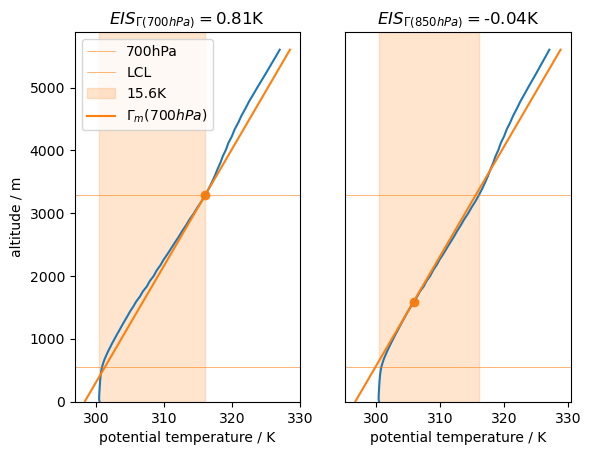

In [37]:
index_700hPa = cc.index_of_nearest_value(d.pres.values, 70000)
index_lcl =  lcl_height(d, return_index=True)

fig, axs = plt.subplots(1, 2)
y = d.height.values
axline_kwargs = dict(color='tab:orange', lw=.4)

for ax in axs:
    ax.plot(d['theta'], y)
    ax.axhline(y[index_700hPa], **axline_kwargs, label=f'700hPa')
    ax.axhline(y[index_lcl], **axline_kwargs, label='LCL')
    ax.axvspan(theta[index_700hPa], theta[-1], color=axline_kwargs['color'], alpha=.2, label=f'{lts:.1f}K')
    ax.set_ylim(0,None)
    ax.set_xlabel('potential temperature / K')

for ax, ref_plevel in zip(axs, [7e4, 8.5e4]):
    index = cc.index_of_nearest_value(d.pres.values, ref_plevel)
    linear_theta = linear_theta_function(d, ref_plevel)
    
    ax.scatter(d['theta'].values[index], y[index], color='tab:orange')
    ax.plot(linear_theta(y), y, color='tab:orange', label=f'$\Gamma_m({int(ref_plevel/100)}hPa)$')
    
    lts = theta[index_700hPa] - theta[-1]
    lapse_rate_stability =  linear_theta(d['height'].values[index_700hPa]) - linear_theta(d['height'].values[index_lcl])
    ax.set_title(f'$EIS_{{\Gamma({int(ref_plevel/100)}hPa)}} =$'+f'{(lts * metpy.units.units("kelvin") - lapse_rate_stability).magnitude:.2f}K')
    
axs[0].set_ylabel('altitude / m')
axs[0].legend()
axs[1] = pu.remove_ticks(axs[1], ['left', 'right'])

fig.show()

## LCL Histogram

In [1]:
import sys
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)

import file_handling as fh
import postprocessing as pp
fh.disable_warnings()

Any code that generates warnings will no longer print them to the console.


In [4]:
import metpy.calc
import metpy.units
import numpy as np
    
def lcl_pres(data):    
    pressure          = d['pres'].load() * metpy.units.units('Pa')
    temperature       = d['temp'].load() * metpy.units.units('K')
    specific_humidity = d['qv'].load()
    dewpoint = metpy.calc.dewpoint_from_specific_humidity(pressure, temperature, specific_humidity)
    try:
        LCL_pres, _ = metpy.calc.lcl(pressure[-1], temperature[-1], dewpoint[-1], eps=1e-2)  # limiting the accuracy to 1% for efficiencies sake
        return LCL_pres.magnitude
    except ValueError:
        return np.nan

data = fh.eureca_data_from_keywords(['3D_DOM01'])
data = data.mean(dim='cell', keep_attrs=True)

lcl_array = list()
print(len(data.time.values), ':')
for i,t in enumerate(data.time.values):
    d = data.sel(time=t)
    lcl_array.append(lcl_pres(d))
    print(i,end=',')
print()

328 :
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,

In [16]:
import xarray as xr 

# lcl_values = ([np.ravel(e)[0] for e in lcl_array]
lcl_values = np.asarray([np.ravel(e)[0] for e in lcl_array])
lcl_da = xr.DataArray(lcl_values, coords=[data.time], dims=['time'], name='LCL_pres')
data['LCL_pres'] = lcl_da

In [19]:
lcl_da.to_netcdf('data/lcl_ctrl.nc')

In [1]:
#!/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/bin/python
#SBATCH --partition=shared
#SBATCH --account=bb1153
#SBATCH --nodes=1
#SBATCH --time=02:00:00
#SBATCH --mail-type=ALL
#SBATCH --mail-user=hernan.campos@mpimet.mpg.de
#SBATCH --output=%j-%x.log                                                                           

import sys 
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)

import file_handling as fh
import postprocessing as pp
fh.disable_warnings()

import metpy.calc
import metpy.units
import numpy as np
import os
import xarray as xr

import builtins
def print(*args, **kwargs):
    ''' for printing into SLURM logs'''
    builtins.print(*args, **kwargs, flush=True)
    
def lcl_pres(data):    
    pressure          = d['pres'].load() * metpy.units.units('Pa')
    temperature       = d['temp'].load() * metpy.units.units('K')
    specific_humidity = d['qv'].load()
    dewpoint = metpy.calc.dewpoint_from_specific_humidity(pressure, temperature, specific_humidity)
    try:
        LCL_pres, _ = metpy.calc.lcl(pressure[-1], temperature[-1], dewpoint[-1], eps=1e-2)  # limiti
        return LCL_pres.magnitude
    except ValueError:
        return np.nan

def load_data(exp_dir = '/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_05/',
              file_slice=slice(50,53)):
    # kind = '3D'
    # data = fh.disk_data_from_keywords(exp_dir, [kind, 'DOM01'], return_file_list=1)
    # data = data[file_slice]

    # exp_dir   = '/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_05/'
    
    file_list = [os.path.join(exp_dir, f) for f in os.listdir(exp_dir)]
    for keyword in ['3D', 'DOM01']:
        file_list = [f for f in file_list if keyword in f]    
    data = xr.open_mfdataset(file_list, concat_dim="time", combine="nested")
    # data = xr.open_mfdataset(file_list, chunks={}, combine='by_coords')
    # data = data.mean(dim='ncells', keep_attrs=True)
    # data = xr.open_mfdataset(data)
    data = pp.clean_volume_data(data)
    data = pp.replace_height_indices_with_values(data)
    data = data.mean(dim='cell', keep_attrs=True)
    return data


print('loading data')
data = load_data()
lcl_array = list()
print('stepwise calculation')
print('')
for t in data.time.values:
    print(t,end=': ')
    try:
        d = data.sel(time=t)
        lcl_array.append(lcl_pres(d))
        print('SUCESS')
    except:
        lcl_array.append(np.nan)
        print('FAIL')
print('')

print('converting to xr.DataArray')
lcl_values = np.asarray([np.ravel(e)[0] for e in lcl_array])
lcl_da = xr.DataArray(lcl_values, coords=[load_data().time], dims=['time'], name='LCL_pres')
print('writing to netCDF')
try:
    save_directory = 'home/m/m300872/warm_eurec4a/03_adiabatic_warming/data'
    print(f'trying to save to {save_directory}')
    lcl_da.to_netcdf(os.path.join(save_directory, 'lcl_warm.nc'))
except:
    print(f'failed. trying to save locally')
    lcl_da.to_netcdf('data_lcl_000001.nc')
print('DONE')

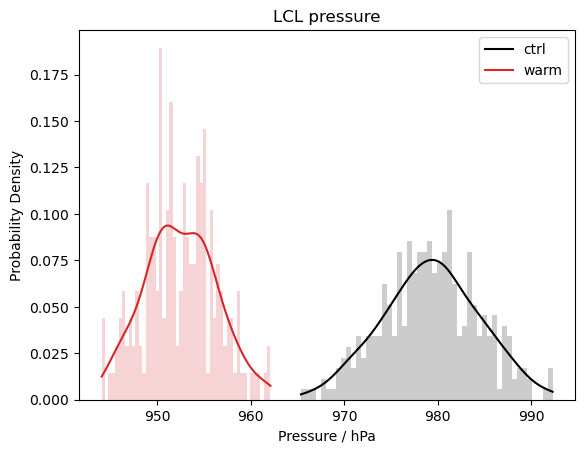

In [55]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

fig, ax = plt.subplots()
datasets = [xr.open_dataset('data/lcl_ctrl.nc'), xr.open_dataset('data/lcl_warm.nc')]
labels = ['ctrl', 'warm']
colors = ['black', 'tab:red']

for data, label, color in zip(datasets, labels, colors):
    data = data['LCL_pres'].values.flatten()  # Convert to a 1D NumPy array
    data = data[~np.isnan(data)]
    data = data / 100
    
    kde = scipy.stats.gaussian_kde(data)
    x_range = np.linspace(np.min(data), np.max(data), 1000)
    pdf_values = kde(x_range)
    plt.hist(data, bins=50, density=True, alpha=0.2, color=color)
    plt.plot(x_range, pdf_values, label=label, color=color)

ax.legend()
ax.set_title('LCL pressure')
ax.set_xlabel('Pressure / hPa')
ax.set_ylabel('Probability Density')
fig.show()

## LCL height

In [1]:
#!/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/bin/python
#SBATCH --partition=compute
#SBATCH --account=bb1153
#SBATCH --nodes=1
#SBATCH --time=02:00:00
#SBATCH --mail-type=ALL
#SBATCH --mail-user=hernan.campos@mpimet.mpg.de
#SBATCH --output=%j-%x.log                                                                           

import sys 
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)

import file_handling as fh
import postprocessing as pp
fh.disable_warnings()

import calculations as cc
import os
import datetime
import numpy as np
import xarray as xr

import builtins
def print(*args, **kwargs):
    ''' for printing into SLURM logs'''
    builtins.print(*args, **kwargs, flush=True)

def timestamp(): return datetime.datetime.now().strftime("%Y%m%d%H%M%S")

def load_data(exp_dir = '/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_05/'):
    file_list = [os.path.join(exp_dir, f) for f in os.listdir(exp_dir)]
    for keyword in ['3D', 'DOM01']:
        file_list = [f for f in file_list if keyword in f]    
    data = xr.open_mfdataset(file_list, concat_dim="time", combine="nested")
    data = pp.clean_volume_data(data)
    data = pp.replace_height_indices_with_values(data)
    data = data['pres']
    data = data.mean(dim='cell', keep_attrs=True)
    # lcl  = xr.open_dataset('data/lcl_ctrl.nc')
    lcl  = xr.open_dataset('data/lcl_warm.nc')
    data = xr.merge([data, lcl])
    data = data.sortby('time')
    return data

print('loading data')
data = load_data()
print('stepwise calculation')
lcl_height = list()
print('')
for t in data.time.values:
    print(t, end='')
    d = data.sel(time=t)
    try:
        index = cc.index_of_nearest_value(d['pres'].values, d['LCL_pres'].values)
        val = d.height.values[index]
        lcl_height.append(val)
        print(f': SUCCESS', int(val))
    except:
        lcl_height.append(np.nan)
        print(f': FAIL')
print('')
print('converting to xr.DataArray')
values = np.asarray([np.ravel(e)[0] for e in lcl_height])
da = xr.DataArray(values, coords=[load_data().time], dims=['time'], name='lcl_height')
lcl_height = da

print('writing to netCDF')
try:
    save_directory = '/home/m/m300872/warm_eurec4a/03_adiabatic_warming/data'
    print(f'trying to save to {save_directory}')
    file_name = os.path.join(save_directory, f'lcl_height_warm.nc')
    lcl_height.to_netcdf(file_name)
    print(f'saved to {file_name}')
    print('SUCCESS')
except:
    print(f'failed. trying to save locally')
    file_name = f'lcl_height_{timestamp()}_warm.nc'
    lcl_height.to_netcdf(file_name)
    print(f'saved to {file_name}')
    print('SUCCESS')
print('DONE')

In [2]:
#!/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/bin/python
#SBATCH --partition=compute
#SBATCH --account=bb1153
#SBATCH --nodes=1
#SBATCH --time=02:00:00
#SBATCH --mail-type=ALL
#SBATCH --mail-user=hernan.campos@mpimet.mpg.de
#SBATCH --output=%j-%x.log                                                                           

import sys 
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)

import file_handling as fh
import postprocessing as pp
fh.disable_warnings()

import calculations as cc
import os
import datetime
import numpy as np
import xarray as xr

import builtins
def print(*args, **kwargs):
    ''' for printing into SLURM logs'''
    builtins.print(*args, **kwargs, flush=True)

def timestamp(): return datetime.datetime.now().strftime("%Y%m%d%H%M%S")

def load_data(exp_dir = '/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_05/'):
    # file_list = [os.path.join(exp_dir, f) for f in os.listdir(exp_dir)]
    # for keyword in ['3D', 'DOM01']:
    #     file_list = [f for f in file_list if keyword in f]    
    # data = xr.open_mfdataset(file_list, concat_dim="time", combine="nested")
    # data = pp.clean_volume_data(data)
    data = fh.eureca_data_from_keywords(['3D_DOM01'])
    data = pp.replace_height_indices_with_values(data)
    data = data['pres']
    data = data.mean(dim='cell', keep_attrs=True)
    # lcl  = xr.open_dataset('data/lcl_ctrl.nc')
    lcl  = xr.open_dataset('data/lcl_ctrl.nc')
    data = xr.merge([data, lcl])
    data = data.sortby('time')
    return data

print('loading data')
data = load_data()
print('stepwise calculation')
lcl_height = list()
print('')
for t in data.time.values:
    print(t, end='')
    d = data.sel(time=t)
    try:
        index = cc.index_of_nearest_value(d['pres'].values, d['LCL_pres'].values)
        val = d.height.values[index]
        lcl_height.append(val)
        print(f': SUCCESS', int(val))
    except:
        lcl_height.append(np.nan)
        print(f': FAIL')
print('')
print('converting to xr.DataArray')
values = np.asarray([np.ravel(e)[0] for e in lcl_height])
da = xr.DataArray(values, coords=[load_data().time], dims=['time'], name='lcl_height')
lcl_height = da

print('writing to netCDF')
try:
    save_directory = '/home/m/m300872/warm_eurec4a/03_adiabatic_warming/data'
    print(f'trying to save to {save_directory}')
    file_name = os.path.join(save_directory, f'lcl_height_ctrl.nc')
    lcl_height.to_netcdf(file_name)
    print(f'saved to {file_name}')
    print('SUCCESS')
except:
    print(f'failed. trying to save locally')
    file_name = f'lcl_height_{timestamp()}_ctrl.nc'
    lcl_height.to_netcdf(file_name)
    print(f'saved to {file_name}')
    print('SUCCESS')
print('DONE')

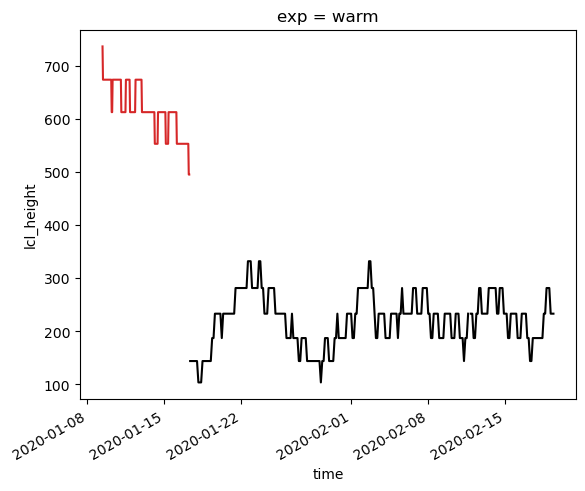

In [20]:
import xarray as xr
import matplotlib.pyplot as plt

data = xr.merge([xr.open_dataset('data/lcl_height_ctrl.nc').expand_dims({'exp':['ctrl']}),
                 xr.open_dataset('data/lcl_height_warm.nc').expand_dims({'exp':['warm']})])

fig, ax = plt.subplots()
for exp, color in zip(data.exp.values, ['black', 'tab:red']):
    d = data.sel(exp=exp)['lcl_height']
    d.plot(ax=ax, color=color)
fig.show()

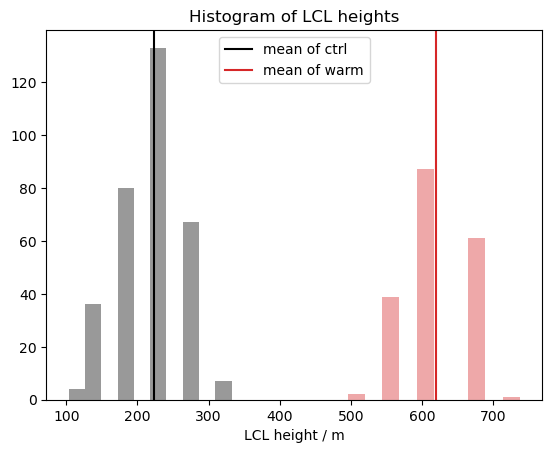

In [33]:
import xarray as xr
import matplotlib.pyplot as plt

data = xr.merge([
    xr.open_dataset('data/lcl_height_ctrl.nc').expand_dims({'exp':['ctrl']}),
    xr.open_dataset('data/lcl_height_warm.nc').expand_dims({'exp':['warm']})])

fig, ax = plt.subplots()
for exp, color in zip(data.exp.values, ['black', 'tab:red']):
    d = data.sel(exp=exp)['lcl_height']
    ax.hist(d, bins=10, color=color, alpha=0.4)
    ax.axvline(d.mean(dim='time'), color=color, label=f'mean of {exp}')
    
ax.set_title('Histogram of LCL heights')
ax.set_xlabel('LCL height / m')
ax.legend()
fig.show()

## Potential temperatures at pressure levels

In [30]:
#!/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/bin/python
#SBATCH --partition=compute
#SBATCH --account=bb1153
#SBATCH --nodes=1
#SBATCH --time=02:00:00
#SBATCH --mail-type=ALL
#SBATCH --mail-user=hernan.campos@mpimet.mpg.de
#SBATCH --output=%j-%x.log                                                                           

import sys 
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)

import file_handling as fh
import postprocessing as pp
fh.disable_warnings()

import calculations as cc
import os
import datetime
import numpy as np
import xarray as xr

import builtins
def print(*args, **kwargs):
    ''' for printing into SLURM logs'''
    builtins.print(*args, **kwargs, flush=True)

def timestamp(): return datetime.datetime.now().strftime("%Y%m%d%H%M%S")

def load_data(exp_dir = '/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_05/'):
    file_list = [os.path.join(exp_dir, f) for f in os.listdir(exp_dir)]
    for keyword in ['3D', 'DOM01']:
        file_list = [f for f in file_list if keyword in f]    
    data = xr.open_mfdataset(file_list, concat_dim="time", combine="nested")
    data = pp.clean_volume_data(data)
    data = pp.replace_height_indices_with_values(data)
    data = data.mean(dim='cell', keep_attrs=True)
    return data

print('loading data')
data = load_data()
plevels = [int(pl) for pl in [7e4,8.5e4, 12e4]]
plevel_theta = {plevel:list() for plevel in plevels}
print('stepwise calculation')
print('')
for t in data.time.values:
    print(t,end=': \n')
    d = data.sel(time=t)
    d = cc.add_prognostic_variables(d)
    for plevel in plevels:
        try:
            index = cc.index_of_nearest_value(d.pres, plevel)
            plevel_theta[plevel].append(d['theta'].values[index])
            print(f'\t{plevel}: SUCCESS')
        except:
            plevel_theta[plevel].append(np.nan)
            print(f'\t{plevel}: FAIL')
print('')
print('converting to xr.DataArray')
for plevel in plevels:
    values = np.asarray([np.ravel(e)[0] for e in plevel_theta[plevel]])
    da = xr.DataArray(values, coords=[load_data().time, dims=['time'], name='theta')
    plevel_theta[plevel] = da

print('writing to netCDF')
for plevel in plevels:
    try:
        save_directory = '/home/m/m300872/warm_eurec4a/03_adiabatic_warming/data'
        print(f'trying to save to {save_directory}')
        file_name = os.path.join(save_directory, f'plevel_theta_{str(plevel)}_warm.nc')
        plevel_theta[plevel].to_netcdf(file_name)
        print(f'saved to {file_name}')
        print('SUCCESS')
    except:
        print(f'failed. trying to save locally')
        file_name = f'plevel_theta_{str(plevel)}_{timestamp()}_warm.nc'
        plevel_theta[plevel].to_netcdf(file_name)
        print(f'saved to {file_name}')
        print('SUCCESS')
    print('DONE')

Any code that generates warnings will no longer print them to the console.
loading data
stepwise calculation

2020-01-11T15:00:00.000000000: 
	70000: SUCCESS
	85000: SUCCESS
	120000: SUCCESS
2020-01-17T02:00:00.000000000: 
	70000: SUCCESS
	85000: SUCCESS
	120000: SUCCESS
2020-01-11T03:00:00.000000000: 
	70000: SUCCESS
	85000: SUCCESS
	120000: SUCCESS

converting to xr.DataArray
writing to netCDF
trying to save to home/m/m300872/warm_eurec4a/03_adiabatic_warming/data
failed. trying to save locally
saved to plevel_theta_70000_20240628163309.nc
SUCCESS
DONE
trying to save to home/m/m300872/warm_eurec4a/03_adiabatic_warming/data
failed. trying to save locally
saved to plevel_theta_85000_20240628163309.nc
SUCCESS
DONE
trying to save to home/m/m300872/warm_eurec4a/03_adiabatic_warming/data
failed. trying to save locally
saved to plevel_theta_120000_20240628163310.nc
SUCCESS
DONE


In [36]:
#!/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/bin/python
#SBATCH --partition=compute
#SBATCH --account=bb1153
#SBATCH --nodes=1
#SBATCH --time=02:00:00
#SBATCH --mail-type=ALL
#SBATCH --mail-user=hernan.campos@mpimet.mpg.de
#SBATCH --output=%j-%x.log                                                                           

import sys 
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)

import file_handling as fh
import postprocessing as pp
fh.disable_warnings()

import calculations as cc
import os
import datetime
import numpy as np
import xarray as xr

import builtins
def print(*args, **kwargs):
    ''' for printing into SLURM logs'''
    builtins.print(*args, **kwargs, flush=True)

def timestamp(): return datetime.datetime.now().strftime("%Y%m%d%H%M%S")

def load_data(exp_dir = '/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_05/'):
    # file_list = [os.path.join(exp_dir, f) for f in os.listdir(exp_dir)]
    # for keyword in ['3D', 'DOM01']:
    #     file_list = [f for f in file_list if keyword in f]    
    # data = xr.open_mfdataset(file_list, concat_dim="time", combine="nested")
    # data = pp.clean_volume_data(data)
    data = fh.eureca_data_from_keywords(['3D', 'DOM01'])
    data = pp.replace_height_indices_with_values(data)
    data = data.mean(dim='cell', keep_attrs=True)
    return data

print('loading data')
data = load_data()
plevels = [int(pl) for pl in [7e4,8.5e4, 12e4]]
plevel_theta = {plevel:list() for plevel in plevels}
print('stepwise calculation')
print('')
for t in data.time.values:
    print(t,end=': \n')
    d = data.sel(time=t)
    d = cc.add_prognostic_variables(d)
    for plevel in plevels:
        try:
            index = cc.index_of_nearest_value(d.pres, plevel)
            plevel_theta[plevel].append(d['theta'].values[index])
            print(f'\t{plevel}: SUCCESS')
        except:
            plevel_theta[plevel].append(np.nan)
            print(f'\t{plevel}: FAIL')
print('')
print('converting to xr.DataArray')
for plevel in plevels:
    values = np.asarray([np.ravel(e)[0] for e in plevel_theta[plevel]])
    # da = xr.DataArray(values, coords=[load_data().time, dims=['time'], name='theta')
    da = xr.DataArray(values, coords=[load_data().time.values, dims=['time'], name='theta')
    plevel_theta[plevel] = da

print('writing to netCDF')
for plevel in plevels:
    try:
        save_directory = '/home/m/m300872/warm_eurec4a/03_adiabatic_warming/data'
        print(f'trying to save to {save_directory}')
        file_name = os.path.join(save_directory, f'plevel_theta_{str(plevel)}_ctrl.nc')
        plevel_theta[plevel].to_netcdf(file_name)
        print(f'saved to {file_name}')
        print('SUCCESS')
    except:
        print(f'failed. trying to save locally')
        file_name = f'plevel_theta_{str(plevel)}_{timestamp()}_ctrl.nc'
        plevel_theta[plevel].to_netcdf(file_name)
        print(f'saved to {file_name}')
        print('SUCCESS')
    print('DONE')

Any code that generates warnings will no longer print them to the console.
loading data
stepwise calculation

2020-01-09T12:00:00.000000000: 
	70000: SUCCESS
	85000: SUCCESS
	120000: SUCCESS
2020-01-09T15:00:00.000000000: 
	70000: SUCCESS
	85000: SUCCESS
	120000: SUCCESS
2020-01-09T18:00:00.000000000: 
	70000: SUCCESS
	85000: SUCCESS
	120000: SUCCESS

converting to xr.DataArray
writing to netCDF
trying to save to home/m/m300872/warm_eurec4a/03_adiabatic_warming/data
failed. trying to save locally
saved to plevel_theta_70000_20240628163909.nc
SUCCESS
DONE
trying to save to home/m/m300872/warm_eurec4a/03_adiabatic_warming/data
failed. trying to save locally
saved to plevel_theta_85000_20240628163909.nc
SUCCESS
DONE
trying to save to home/m/m300872/warm_eurec4a/03_adiabatic_warming/data
failed. trying to save locally
saved to plevel_theta_120000_20240628163909.nc
SUCCESS
DONE


In [15]:
import os
import subprocess

def new_name(old_name):
    old_name = old_name.split('.')[0]
    dim_type, var, plevel, timestamp, exp = old_name.split('_')
    return f'{var}_{plevel}_{exp}.nc'

source_directory = '/home/m/m300872'
target_directory = '/home/m/m300872/warm_eurec4a/03_adiabatic_warming/data'
file_list = os.listdir(source_directory)
file_list = [f for f in file_list if f.endswith('.nc')]
file_list = [f for f in file_list if f.startswith('plevel')]
target_files = [new_name(f) for f in file_list]
target_files = [os.path.join(target_directory, f) for f in target_files]
source_files = [os.path.join(source_directory, f) for f in file_list]
for s,t in zip(source_files, target_files): 
    print(s,'->',t)
    subprocess.call(['mv',s,t])

/home/m/m300872/plevel_theta_70000_20240628175605_ctrl.nc -> /home/m/m300872/warm_eurec4a/03_adiabatic_warming/data/theta_70000_ctrl.nc
/home/m/m300872/plevel_theta_120000_20240628175605_ctrl.nc -> /home/m/m300872/warm_eurec4a/03_adiabatic_warming/data/theta_120000_ctrl.nc
/home/m/m300872/plevel_theta_70000_20240628182155_warm.nc -> /home/m/m300872/warm_eurec4a/03_adiabatic_warming/data/theta_70000_warm.nc
/home/m/m300872/plevel_theta_85000_20240628182155_warm.nc -> /home/m/m300872/warm_eurec4a/03_adiabatic_warming/data/theta_85000_warm.nc
/home/m/m300872/plevel_theta_85000_20240628175605_ctrl.nc -> /home/m/m300872/warm_eurec4a/03_adiabatic_warming/data/theta_85000_ctrl.nc
/home/m/m300872/plevel_theta_120000_20240628182155_warm.nc -> /home/m/m300872/warm_eurec4a/03_adiabatic_warming/data/theta_120000_warm.nc


In [40]:
pls = [70000, 85000, 120000]
for pl in pls:
    print(pl/12e4)

0.5833333333333334
0.7083333333333334
1.0


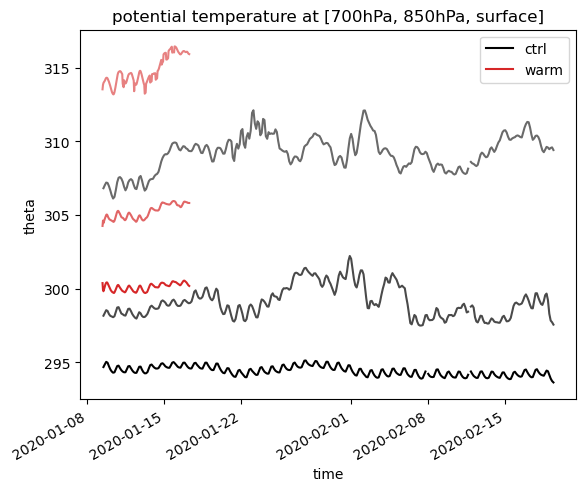

In [49]:
import os
import xarray as xr
import matplotlib.pyplot as plt

target_directory = '/home/m/m300872/warm_eurec4a/03_adiabatic_warming/data'
file_list = os.listdir(target_directory)
file_list = [f for f in file_list if f.startswith('theta') and f.endswith('.nc')]
file_list = [os.path.join(target_directory,f) for f in file_list]

fig, ax = plt.subplots()
datasets = list()
for f in file_list:
    var, plevel, exp = f.split('/')[-1].split('.')[0].split('_')
    da = xr.open_dataset(f).expand_dims(dim={'exp':[exp], 'plevel':[int(plevel)]})
    da = da.sortby('time')
    datasets.append(da)
    color = 'tab:red' if da.exp.values == 'warm' else 'black'
    alpha = da.plevel.values[0]/12e4
    label = da.exp.values[0] if alpha == 1.0 else None
    da['theta'].plot(ax=ax, color=color, alpha=alpha, label=label)
    
data = xr.merge(datasets)
ax.legend()
ax.set_title('potential temperature at [700hPa, 850hPa, surface]')
fig.show()

### LCL potential temperature

In [44]:
#!/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/bin/python
#SBATCH --partition=compute
#SBATCH --account=bb1153
#SBATCH --nodes=1
#SBATCH --time=02:00:00
#SBATCH --mail-type=ALL
#SBATCH --mail-user=hernan.campos@mpimet.mpg.de
#SBATCH --output=%j-%x.log                                                                           

import sys 
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)

import file_handling as fh
import postprocessing as pp
fh.disable_warnings()

import calculations as cc
import os
import datetime
import numpy as np
import xarray as xr

import builtins
def print(*args, **kwargs):
    ''' for printing into SLURM logs'''
    builtins.print(*args, **kwargs, flush=True)

def timestamp(): return datetime.datetime.now().strftime("%Y%m%d%H%M%S")

def load_data(exp_dir = '/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_05/'):
    file_list = [os.path.join(exp_dir, f) for f in os.listdir(exp_dir)]
    for keyword in ['3D', 'DOM01']:
        file_list = [f for f in file_list if keyword in f]    
    data = xr.open_mfdataset(file_list, concat_dim="time", combine="nested")
    data = pp.clean_volume_data(data)
    data = pp.replace_height_indices_with_values(data)
    # data = data['pres']
    data = data.mean(dim='cell', keep_attrs=True)
    # lcl  = xr.open_dataset('data/lcl_ctrl.nc')
    lcl  = xr.open_dataset('
    data/lcl_height_warm.nc')
    data = xr.merge([data, lcl])
    data = data.sortby('time')
    return data

print('loading data')
data = load_data()
print('stepwise calculation')
lcl_theta = list()
print('')
for t in data.time.values:
    print(t, end='')
    d = data.sel(time=t)
    d = cc.add_prognostic_variables(d)
    try:
        index = cc.index_of_nearest_value(d['pres'].values, d['lcl_height'].values)
        val = d.theta.values[index]
        lcl_theta.append(val)
        print(f': SUCCESS', f'{val:.1f}')
    except:
        lcl_theta.append(np.nan)
        print(f': FAIL')
print('')
print('converting to xr.DataArray')
values = np.asarray([np.ravel(e)[0] for e in lcl_theta])
da = xr.DataArray(values, coords=[load_data().time], dims=['time'], name='theta_lcl')
lcl_theta = da

print('writing to netCDF')
try:
    save_directory = '/home/m/m300872/warm_eurec4a/03_adiabatic_warming/data'
    print(f'trying to save to {save_directory}')
    file_name = os.path.join(save_directory, f'lcl_theta_warm.nc')
    lcl_height.to_netcdf(file_name)
    print(f'saved to {file_name}')
    print('SUCCESS')
except:
    print(f'failed. trying to save locally')
    file_name = f'lcl_theta_{timestamp()}_warm.nc'
    lcl_height.to_netcdf(file_name)
    print(f'saved to {file_name}')
    print('SUCCESS')
print('DONE')

In [43]:
#!/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/bin/python
#SBATCH --partition=compute
#SBATCH --account=bb1153
#SBATCH --nodes=1
#SBATCH --time=02:00:00
#SBATCH --mail-type=ALL
#SBATCH --mail-user=hernan.campos@mpimet.mpg.de
#SBATCH --output=%j-%x.log                                                                           

import sys 
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)

import file_handling as fh
import postprocessing as pp
fh.disable_warnings()

import calculations as cc
import os
import datetime
import numpy as np
import xarray as xr

import builtins
def print(*args, **kwargs):
    ''' for printing into SLURM logs'''
    builtins.print(*args, **kwargs, flush=True)

def timestamp(): return datetime.datetime.now().strftime("%Y%m%d%H%M%S")

def load_data(exp_dir = '/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_05/'):
    # file_list = [os.path.join(exp_dir, f) for f in os.listdir(exp_dir)]
    # for keyword in ['3D', 'DOM01']:
    #     file_list = [f for f in file_list if keyword in f]    
    # data = xr.open_mfdataset(file_list, concat_dim="time", combine="nested")
    # data = pp.clean_volume_data(data)
    data = fh.eureca_data_from_keywords(['3D_DOM01'])
    data = pp.replace_height_indices_with_values(data)
    # data = data['pres']
    data = data.mean(dim='cell', keep_attrs=True)
    # lcl  = xr.open_dataset('data/lcl_ctrl.nc')
    lcl  = xr.open_dataset('/home/m/m300872/warm_eurec4a/03_adiabatic_warming/data/lcl_height_ctrl.nc')
    data = xr.merge([data, lcl])
    data = data.sortby('time')
    return data

print('loading data')
data = load_data()
print('stepwise calculation')
lcl_theta = list()
print('')
for t in data.time.values:
    print(t, end='')
    d = data.sel(time=t)
    d = cc.add_prognostic_variables(d)
    try:
        index = cc.index_of_nearest_value(d['pres'].values, d['lcl_height'].values)
        val = d.theta.values[index]
        lcl_theta.append(val)
        print(f': SUCCESS', f'{val:.1f}')
    except:
        lcl_theta.append(np.nan)
        print(f': FAIL')
print('')
print('converting to xr.DataArray')
values = np.asarray([np.ravel(e)[0] for e in lcl_theta])
da = xr.DataArray(values, coords=[load_data().time], dims=['time'], name='theta_lcl')
lcl_theta = da

print('writing to netCDF')
try:
    save_directory = '/home/m/m300872/warm_eurec4a/03_adiabatic_warming/data'
    print(f'trying to save to {save_directory}')
    file_name = os.path.join(save_directory, f'lcl_theta_ctrl.nc')
    lcl_theta.to_netcdf(file_name)
    print(f'saved to {file_name}')
    print('SUCCESS')
except:
    print(f'failed. trying to save locally')
    file_name = f'lcl_theta_{timestamp()}_ctrl.nc'
    lcl_theta.to_netcdf(file_name)
    print(f'saved to {file_name}')
    print('SUCCESS')
print('DONE')

In [46]:
import os
import xarray as xr

save_directory = '/home/m/m300872/warm_eurec4a/03_adiabatic_warming/data'
experiments = ['ctrl', 'warm']
datasets = list()
for exp in experiments:
    file_name = os.path.join(save_directory, f'lcl_theta_{exp}.nc'))
    dataset   = xr.open_dataset(file_name)
    dataset   = dataset.expand_dims(exp=[exp])
    datasets.append(dataset)
data = xr.merge(datasets)
data

'/home/m/m300872/warm_eurec4a/03_adiabatic_warming/data/lcl_theta_ctrl.nc'

### cloud top height

The idea here is to mark the cloud top height as the first level that passes a threshold, looking from above. This is a proof of concept, using nextgems data:

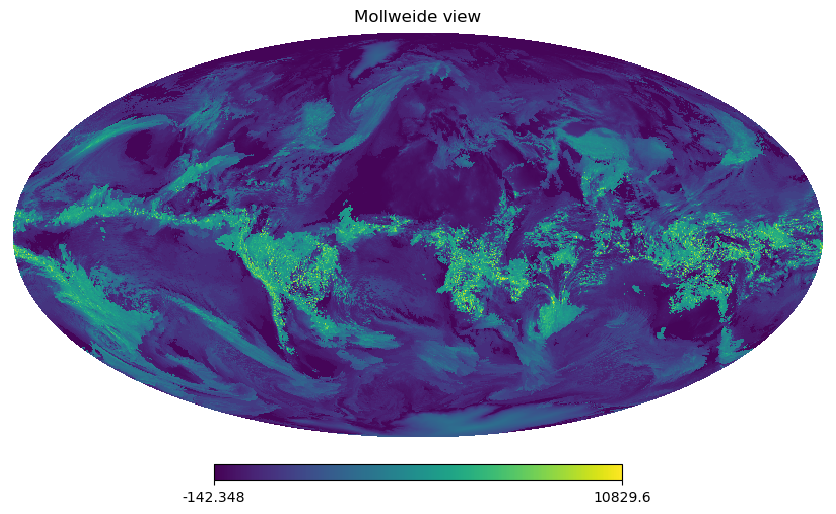

In [71]:
import intake
import healpy as hp
import numpy as np

# load data
cat = intake.open_catalog("https://data.nextgems-h2020.eu/catalog.yaml")
ds = cat.ICON.ngc4008(zoom=8).to_dask().isel(time=slice(0, 2))

# make a boolean cloud mask and find the `argmax`. `argmax` returns the index of the highest value. 
# This is the index of our cloud top height for two reasons: highest boolean is `True` and ICON indexes its height levels starting from the model top
cloud = ds.clw > 1e-5
cloud_height = cloud.argmax(dim="level_full").isel(time=0)

# So far we got the index of the threshold passing. we want to translate this into a height in meters.
# also rather than having the model top for cloud free cases, we would rather have the surface height (or `None`)
ground_level = int(np.max(ds['level_full'].values)) - 1
cloud_height = cloud_height.where(cloud_height != 0, ground_level)
cloud_height = ds.zg.isel(level_full=cloud_height)

hp.mollview(cloud_height, nest=True, flip="geo")

In [5]:
#!/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/bin/python
#SBATCH --partition=compute
#SBATCH --account=bb1153
#SBATCH --nodes=1
#SBATCH --time=02:00:00
#SBATCH --mail-type=ALL
#SBATCH --mail-user=hernan.campos@mpimet.mpg.de
#SBATCH --output=%j-%x.log                                                                           

import sys 
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)

import file_handling as fh
import postprocessing as pp
fh.disable_warnings()

import calculations as cc
import os
import datetime
import numpy as np
import xarray as xr
import pandas as pd

import builtins
def print(*args, **kwargs):
    ''' for printing into SLURM logs'''
    builtins.print(*args, **kwargs, flush=True)

def timestamp(): return datetime.datetime.now().strftime("%Y%m%d%H%M%S")

def load_data(exp_dir='/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_05/'):
    if exp_dir == None:
        data = fh.eureca_data_from_keywords(['3D_DOM01'])
    else:
        file_list = [os.path.join(exp_dir, f) for f in os.listdir(exp_dir)]
        for keyword in ['3D', 'DOM01']:
            file_list = [f for f in file_list if keyword in f]    
        data = xr.open_mfdataset(file_list, concat_dim="time", combine="nested")
        data = pp.clean_volume_data(data)
    data = pp.replace_height_indices_with_values(data)
    return data

print('loading data')
data = load_data()
print('stepwise calculation')
temp_dir = '/scratch/m/m300872/cloud_top'
print('')
for t in data.time.values:
    print(t,end=': ')
    d = data.sel(time=t)
    d = d.expand_dims(time=[t])

    try:
        cloud = d['qc'] > 1e-5
        cloud_height = cloud.argmax(dim="height").compute()
        
        ground_level = 67 # we got 68 height levels
        cloud_height = cloud_height.where(cloud_height != 0, ground_level)
        cloud_height = d['height'].isel(height=cloud_height)
    
        filename = f'cth_warm_{pd.to_datetime(t).strftime("%Y%m%d%H%M%S")}.nc'
        cloud_height.to_netcdf(os.path.join(temp_dir,filename))
        print('SUCCESS')
    except:
        print('FAIL')

Any code that generates warnings will no longer print them to the console.
loading data
stepwise calculation

2020-01-09T12:00:00.000000000: SUCCESS
2020-01-09T15:00:00.000000000: SUCCESS


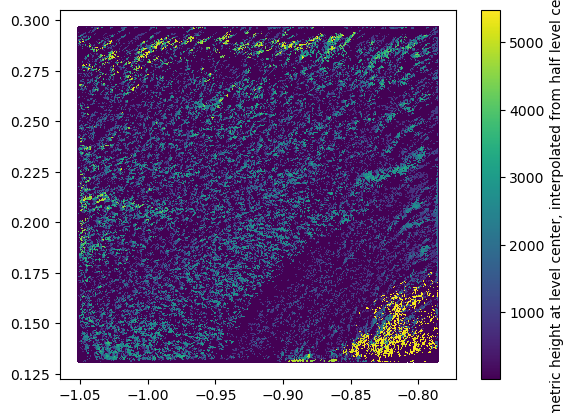

In [6]:
# make a plot from the remnants of the above script we still have in memory:
import matplotlib.pyplot as plt
import plot_utils as pu
fig, ax = plt.subplots()
cloud_height = pp.add_grid(cloud_height.to_dataset(name='cloud_top'), clean=False, drop_vars=False)
ax = pu.ax_triangles(ax, cloud_height, 'cloud_top') 
fig.show()

In [4]:
#!/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/bin/python
#SBATCH --partition=compute
#SBATCH --account=bb1153
#SBATCH --nodes=1
#SBATCH --time=02:00:00
#SBATCH --mail-type=ALL
#SBATCH --mail-user=hernan.campos@mpimet.mpg.de
#SBATCH --output=%j-%x.log                                                                           

import sys 
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)

import file_handling as fh
import postprocessing as pp
fh.disable_warnings()

import calculations as cc
import os
import datetime
import numpy as np
import xarray as xr

import builtins
def print(*args, **kwargs):
    ''' for printing into SLURM logs'''
    builtins.print(*args, **kwargs, flush=True)

def timestamp(): return datetime.datetime.now().strftime("%Y%m%d%H%M%S")

def load_data(exp_dir='/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_05/'):
    if exp_dir == None:
        data = fh.eureca_data_from_keywords(['3D_DOM01'])
    else:
        file_list = [os.path.join(exp_dir, f) for f in os.listdir(exp_dir)]
        for keyword in ['3D', 'DOM01']:
            file_list = [f for f in file_list if keyword in f]    
        data = xr.open_mfdataset(file_list, concat_dim="time", combine="nested")
        data = pp.clean_volume_data(data)
    data = pp.replace_height_indices_with_values(data)
    data = data['pres']
    data = data.mean(dim='cell', keep_attrs=True)
    return data

print('loading data')
data = load_data()
print('stepwise calculation')
output = list()
print('')
for t in data.time.values:
    print(t, end='')
    d = data.sel(time=t)
    try:
        index = cc.index_of_nearest_value(d.values, 70000)
        val = d.height.values[index]
        output.append(val)
        print(f': SUCCESS', int(val))
    except:
        output.append(np.nan)
        print(f': FAIL')
print('')
print('converting to xr.DataArray')
values = np.asarray([np.ravel(e)[0] for e in output])
da = xr.DataArray(values, coords=[load_data().time], dims=['time'], name='z700')
output = da

print('writing to netCDF')
try:
    save_directory = '/home/m/m300872/warm_eurec4a/03_adiabatic_warming/data'
    print(f'trying to save to {save_directory}')
    file_name = os.path.join(save_directory, f'700hpa_height_warm.nc')
    output.to_netcdf(file_name)
    print(f'saved to {file_name}')
    print('SUCCESS')
except:
    print(f'failed. trying to save locally')
    file_name = f'700hpa_height_{timestamp()}_warm.nc'
    output.to_netcdf(file_name)
    print(f'saved to {file_name}')
    print('SUCCESS')
print('DONE')

Any code that generates warnings will no longer print them to the console.
loading data
stepwise calculation

2020-01-11T15:00:00.000000000: SUCCESS 3288
2020-01-17T02:00:00.000000000: SUCCESS 3288
2020-01-11T03:00:00.000000000: SUCCESS 3288
2020-01-15T08:00:00.000000000: SUCCESS 3190
2020-01-16T14:00:00.000000000: SUCCESS 3288
2020-01-12T11:00:00.000000000: SUCCESS 3288
2020-01-14T06:00:00.000000000: SUCCESS 3190
2020-01-12T21:00:00.000000000: SUCCESS 3288
2020-01-09T17:00:00.000000000: SUCCESS 3288
2020-01-15T04:00:00.000000000: SUCCESS 3288
2020-01-17T07:00:00.000000000: SUCCESS 3288
2020-01-09T10:00:00.000000000: SUCCESS 3288
2020-01-16T16:00:00.000000000: SUCCESS 3288
2020-01-14T22:00:00.000000000: SUCCESS 3190
2020-01-16T06:00:00.000000000: SUCCESS 3288
2020-01-11T10:00:00.000000000: SUCCESS 3288
2020-01-12T16:00:00.000000000: SUCCESS 3288
2020-01-13T14:00:00.000000000: SUCCESS 3288
2020-01-15T05:00:00.000000000: SUCCESS 3190
2020-01-13T20:00:00.000000000: SUCCESS 3190
2020-01-13

In [ ]:
#!/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/bin/python
#SBATCH --partition=compute
#SBATCH --account=bb1153
#SBATCH --nodes=1
#SBATCH --time=02:00:00
#SBATCH --mail-type=ALL
#SBATCH --mail-user=hernan.campos@mpimet.mpg.de
#SBATCH --output=%j-%x.log                                                                           

import sys 
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)

import file_handling as fh
import postprocessing as pp
fh.disable_warnings()

import calculations as cc
import os
import datetime
import numpy as np
import xarray as xr

import builtins
def print(*args, **kwargs):
    ''' for printing into SLURM logs'''
    builtins.print(*args, **kwargs, flush=True)

def timestamp(): return datetime.datetime.now().strftime("%Y%m%d%H%M%S")

def load_data(exp_dir='/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_05/'):
    if exp_dir == None:
        data = fh.eureca_data_from_keywords(['3D_DOM01'])
    else:
        file_list = [os.path.join(exp_dir, f) for f in os.listdir(exp_dir)]
        for keyword in ['3D', 'DOM01']:
            file_list = [f for f in file_list if keyword in f]    
        data = xr.open_mfdataset(file_list, concat_dim="time", combine="nested")
        data = pp.clean_volume_data(data)
    data = pp.replace_height_indices_with_values(data)
    data = data['pres']
    data = data.mean(dim='cell', keep_attrs=True)
    return data

print('loading data')
data = load_data(None)
print('stepwise calculation')
output = list()
print('')
for t in data.time.values:
    print(t, end='')
    d = data.sel(time=t)
    try:
        index = cc.index_of_nearest_value(d.values, 70000)
        val = d.height.values[index]
        output.append(val)
        print(f': SUCCESS', int(val))
    except:
        output.append(np.nan)
        print(f': FAIL')
print('')
print('converting to xr.DataArray')
values = np.asarray([np.ravel(e)[0] for e in output])
da = xr.DataArray(values, coords=[load_data().time], dims=['time'], name='z700')
output = da

print('writing to netCDF')
try:
    save_directory = '/home/m/m300872/warm_eurec4a/03_adiabatic_warming/data'
    print(f'trying to save to {save_directory}')
    file_name = os.path.join(save_directory, f'700hpa_height_ctrl.nc')
    output.to_netcdf(file_name)
    print(f'saved to {file_name}')
    print('SUCCESS')
except:
    print(f'failed. trying to save locally')
    file_name = f'700hpa_height_{timestamp()}_ctrl.nc'
    output.to_netcdf(file_name)
    print(f'saved to {file_name}')
    print('SUCCESS')
print('DONE')